### Un test d'extraction de moments de tchebichef en 3D

Il montre simplement un test pour la visualisation et n'a pas d'impact sur le data

In [15]:
import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [16]:
# =================================================================
# 1. FONCTIONS MATHÉMATIQUES 3D (Décomposition & Reconstruction)
# =================================================================

def tchebichef_polynomials(N, order):
    M = np.zeros((order, N))
    x = np.arange(N)
    M[0, :] = 1.0
    if order > 1: M[1, :] = (2.0 * x - N + 1.0) / N
    for p in range(2, order):
        M[p, :] = ((2.0*p-1.0)*(2.0*x-N+1.0)/(p*N))*M[p-1,:] - ((p-1.0)/p)*(1.0-((p-1.0)**2/(N**2)))*M[p-2,:]
    return M

def calculate_rho(N, order):
    rho = np.zeros(order); rho[0] = N
    for p in range(1, order): rho[p] = (N**2-p**2)/(N**2) * (2*p-1)/(2*p+1) * rho[p-1]
    return rho

def decompose_3d(volume, order):
    D, H, W = volume.shape
    od, oh, ow = min(order, D), min(order, H), min(order, W)
    Md, Mh, Mw = tchebichef_polynomials(D, od), tchebichef_polynomials(H, oh), tchebichef_polynomials(W, ow)
    rd, rh, rw = calculate_rho(D, od), calculate_rho(H, oh), calculate_rho(W, ow)
    
    # Projection 3D
    T_raw = np.einsum('zyx,pz,qy,rx->pqr', volume, Md, Mh, Mw)
    norm = 1.0 / np.einsum('p,q,r->pqr', rd, rh, rw)
    
    T_final = np.zeros((order, order, order))
    T_final[:od, :oh, :ow] = T_raw * norm
    return T_final # On garde la précision max pour la reconstruction

def reconstruct_3d(moments, shape_originale):
    D, H, W = shape_originale
    order = moments.shape[0]
    # On régénère les bases polynomiales
    Md = tchebichef_polynomials(D, order)
    Mh = tchebichef_polynomials(H, order)
    Mw = tchebichef_polynomials(W, order)
    # Somme pondérée inverse 3D
    # V(z,y,x) = sum_p sum_q sum_r T_pqr * Mz(p,z) * My(q,y) * Mx(r,x)
    return np.einsum('pqr,pz,qy,rx->zyx', moments, Md, Mh, Mw)

In [ ]:
# =================================================================
# 2. PRÉPARATION DES DONNÉES (TEST P1_T1_FLAIR_L1)
# =================================================================

PATIENT, TP, MOD = "P1", "T1", "FLAIR"
# Adaptez ce chemin si nécessaire
BASE = f"../../../data/01_MSLesSeg_Dataset/train/{PATIENT}/{TP}"
ORDRE = 10

print(f"Chargement de {PATIENT} {TP} {MOD}...")
img_arr = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(BASE, f"{PATIENT}_{TP}_{MOD}.nii.gz")))
mask_sitk = sitk.ReadImage(os.path.join(BASE, f"{PATIENT}_{TP}_MASK.nii.gz"))
mask_bin = sitk.Cast(mask_sitk > 0, sitk.sitkUInt8)
# Relabel pour que 1 = plus grosse lésion
mask_arr = sitk.GetArrayFromImage(sitk.RelabelComponent(sitk.ConnectedComponent(mask_bin)))

# Isolation de la lésion L1 (Bounding Box 3D)
indices = np.where(mask_arr == 1)
if indices[0].size == 0: raise ValueError("Lésion L1 introuvable.")

z_min, z_max = indices[0].min(), indices[0].max()
y_min, y_max = indices[1].min(), indices[1].max()
x_min, x_max = indices[2].min(), indices[2].max()

roi_signal = img_arr[z_min:z_max+1, y_min:y_max+1, x_min:x_max+1]
roi_mask = (mask_arr[z_min:z_max+1, y_min:y_max+1, x_min:x_max+1] == 1)
roi_final = roi_signal * roi_mask

# Normalisation 0-1
v_max = np.max(roi_final)
roi_norm = roi_final / v_max if v_max > 0 else roi_final

print(f"Taille du volume ROI : {roi_norm.shape}")

Chargement de P1 T1 FLAIR...
Taille du volume ROI : (75, 88, 36)


Décomposition 3D (Ordre 10, 1000 coeffs)...
Reconstruction 3D...


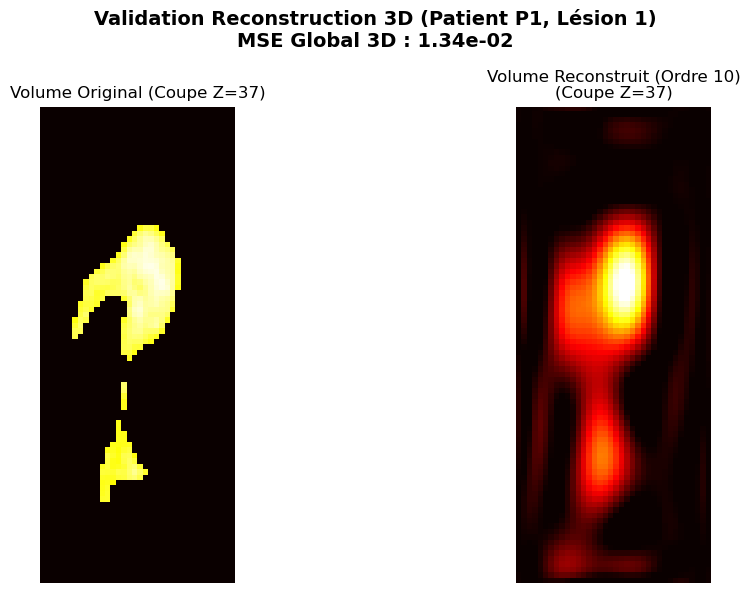

In [18]:
# =================================================================
# 3. TRAITEMENT ET VISUALISATION
# =================================================================

print(f"Décomposition 3D (Ordre {ORDRE}, {ORDRE**3} coeffs)...")
moments_3d = decompose_3d(roi_norm, ORDRE)

print("Reconstruction 3D...")
recons_3d = reconstruct_3d(moments_3d, roi_norm.shape)

# Calcul du MSE Global sur tout le volume 3D
mse_3d_global = np.mean((roi_norm - recons_3d)**2)

# --- Visualisation d'une coupe témoin ---
# On choisit la coupe du milieu sur l'axe Z (axial)
mid_z = roi_norm.shape[0] // 2

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Titre global avec le MSE 3D
fig.suptitle(f"Validation Reconstruction 3D (Patient {PATIENT}, Lésion 1)\nMSE Global 3D : {mse_3d_global:.2e}", fontsize=14, fontweight='bold')

# Image Originale (Coupe Z du milieu)
axes[0].imshow(roi_norm[mid_z, :, :], cmap='hot', vmin=0, vmax=1)
axes[0].set_title(f"Volume Original (Coupe Z={mid_z})")
axes[0].axis('off')

# Image Reconstruite (Même coupe Z du volume reconstruit)
axes[1].imshow(recons_3d[mid_z, :, :], cmap='hot', vmin=0, vmax=1)
axes[1].set_title(f"Volume Reconstruit (Ordre {ORDRE})\n(Coupe Z={mid_z})")
axes[1].axis('off')

plt.tight_layout()
plt.show()